# Sequence Optimisation

## Introduction

This notebook establishes an example of how to optimise a time sequence with a composite genotype.

The real-world case will employ a large simulation outside the scope of this notebook and will use a different fitness function as used here.
This prototype test problem has a synthetic objective and an appropriately  matching fitness function. 

The sequence comprises:

1. A number of events at discrete times where each event has two additional parameters.

1. The events cannot take place simultaneously at a given time, but if the need arises to have to events closely spaced, they will follow in the first available next time slot immediately after any currently occupied time slot.

1. The optimal solution will have ore effective events towards the start of the sequence, with less effective events later in the sequence.  Increased focus should therefore be given to events at the start of the sequence.

This example will optimize towards two objectives: 

- Employ the least number of events.  This is a very simple test: count the number of events and penalise too high counts.

- Optimise for the minimum distance between the required (test) sequence(s) and the presently tested sequence. For this example a number of required sequences are posed, where each sequence will have equal weight.

A key consideration in the real-world problem is that there probably is no clear global minimum.  A number of potentially very different minima are expected, and the solution must balance the performance between the minima. The best fit across all minima will be sought but it is conceivable  that some form of preference ordering or weighting might be required, trading some local minima against other local minima. This must be implemented in the real-world fitness function (not considered here).



## Important note!


1. Make sure you read all the DEAP documentation carefully: some problems don't solve for all available optimisations. The trivial problems are easy to get working, because it seems most algorithms work, but complex multi-objective problems like this one will not provide a solution, with no warning of failure. Do your homework!  Google the DEAP group and StackOverflow to look for other similar problems.

1. Some problems are better amenable to higher mutation rates and others to lower mutation rates. The same is also true for the many other parameters. Experiment to find a good solution.

1. Plot or otherwise visualize the results; eyeballing is so much easier to spot strange behaviour.  Towards the end of this notebook I provide some tools to plot the DEAP log captured during the run.

## Hyperparameters

The deep learning community uses the term hyperparameters to describe the parameters that govern the tool that creates the neural net.  Hence, the hyperparameters describe the creation process, a meta-level, above the actual neural network itself.  We use the same terminology here to describe the process that describes the GA algorithms and parameters in these algorithms.

Most textbook EA/GA examples are relatively simple with limited genotype complexity, requiring a simple fitness function and other hyperparameters. 
The sequence problem has a relatively large number of hyperparameters and execution  options, hence setting up and finding the correct hyperparameter blend is quite tricky.  At best a poorly selected set may result in very long run times, and at worst, the solution sequence could be useless.  Setting up the runs therefore requires careful and clear thinking.


## Surrogate or Replacement Model

The real-world model fitness function executes too slow to do the algorithm development in a reasonable time. 
The surrogate sequence (`testSeq` below) and its associated fitness function, `evalSequence()`, serves as stand-in for the real-world process during the initial development and hyperparameter fine tuning. The surrogate cannot really replace the real system, but it does provide scaffolding for the development and debugging of the overall GA model, the genotype design, and the custom mutation and crossover functions.
Once these matters are satisfactorily resolved with the surrogate system, it will be replaced with the real-world system.

## Crossover, Mutation, and Statistical outliers (the tail)

The nature of this problem probably lends itself more towards mutation and less towards crossover, as evidenced by early experimentation. It was found that higher mutation rates leads to more rapid convergence. Note, however, that if the mutation probability approaches one, the crossover  probability approaches zero for the selection algorithm used here (`eaMuPlusLambda` requires that the two values add up to one). When the mutation probability approaches unity, the search effectively becomes a Monte Carlo optimisation, and the memory propagated by crossover is lost.  The present ratio of mutation to crossover is seems to work reasonably well, but is by no means optimised.

As the solution approaches the target sequence, after many iterations, the probability to find better solutions becomes smaller and smaller. 
These 'better' solutions require *joint statistic inputs* that become increasingly rare.
Beyond some threshold, any further improvement just requires brute force calculation and the benefits of the GA is lost. 
With the surrogate model it may be feasible to run thousands of generations and hope for some improvement, but this is not feasible for the real-world solution.
This limitation on large-generation runs again underlines the importance of developing an efficient model and set of hyperparameters.

Finally, experimentation with this model showed that it may be more worthwhile to do four times 500 generations, each time with a different seed value, instead of one times 2000 generations. It is also important to save **every result** of all the runs, because you have no guarantee that a better solution will be found. So some form of configuration control is required to capture the solutions for future reference.

## Multiploidy and Genetic Drift

Multiploidy means  poly-poid genotypes (multiploid) which consists of multiple sets of chromosomes with some mechanism for determining which gene is expressed. Multiploid GA is able to recover from early genetic drift where good genes become lost in the initial selection process. It is useful in those cases where useful genetic material may otherwise be irretrievably lost.
DEAP does not implement multiploidy and hence this investigation cannot evaluate this.

Genetic drift occurs in the present model in the sense that the mutations can 'destroy' one gene in a promising genotype (e.g., the time, or event type or event direction) while searching for a more global minimum. This problem is specific to the surrogate model used here if the genes are mutated and evaluated separately (in the `fitPosNegTime` and `fitDTime` weight cases) and hence the minima for ach of the components are known throughout the generations.  In the real-world problem the independence of these genes are not visible hence the gene drift is hidden (if present) in the single fitness function result.



In [1]:
##

import sys
import array
import random
import numpy as np
import pandas as pd
from enum import Enum,unique
from collections import OrderedDict
from functools import reduce
from operator import add, itemgetter

from deap import  algorithms
from deap import  base
from deap import  creator
from deap import  tools

import matplotlib
import matplotlib.pyplot as plt

# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)

np.set_printoptions(suppress=True)# supress printing of small values
np.set_printoptions(linewidth=200)
np.set_printoptions(precision=6)

%matplotlib inline

## Parameter Set

The parameters are grouped together into coherent sets for each of documentation.

1. **Set 1** The first set of parameters control the DEAP execution: maximum number of generations, population size,  hall-of-fame (hof) size, probabilities of mutation and crossover, and two parameters, `MU` and `LAMBDA` for the `eaMuPlusLambda` selection algorithm.  The hof provide survival of the fittest throughout generations (also known as elitist survival), in other words the individuals have 'eternal' life and don't die at the end of the generation.  Note that the `eaMuPlusLambda` selection algorithm requires that the mutation and crossover probabilities add up to one.

1. **Set 2** controls the inidividual event initialisation.  `FtypeNProbInit` is the probability is of type Ftype.N (which is a non-event, if will disappear from the final sequence. `FtypeMProbInit` is the probability of event type `Ftype.M` if it is not a non-event.  `DirtypePProbInit`  is the probability of event direction  `DirType.P`.  These values are only relevant during the population set up.

1. **Set 3** controls the time parameters for the events.
    - `mutateTimeProb` is the probability of event time mutation, if the event does undergo mutation. Hence the probability of time mutation is actually `mutateTimeProb * MutProb`.
    - `mutateTimeDecProb` is the probability that the time will be mutated towards shorter (zero) time, rather than being shifted towards longer time. In the real-world problem the events at shorter times have more effect, so the mutation must move towards shorter times.
    - `mutateTimeMax` the maximum shift in the time mutation (generated by uniform random number generator).
    - `countPosNeg` (boolean): if `True` count the number of times that the event different from the target sequence.  If `False` calculate the sum of the differences between the target and individual events.
    - `timemax` the duration of the sequence
    - `timeinc` the discretisation interval in time.
 
1. **Set 4** controls the type mutation.
    - `mutateTypeProb` probability of type mutation, in the event that mutation does take place.
    - `FtypeNProbMut` is the probaility that the event will be changed to a non-event. This kills or removes the event from the sequence.
    - `favourRemovalAtTmax` (boolean): if `True` the removal/kill of the event with by biased towards removal of events late in the sequence (better retaining of events early in the sequence).
    - `numNonFTypeN` Sets the minimum number of events in the sequence, when the number of not non-events approaches this number, the events will not be removed.
    - `FtypeProb` If the event is not a non-event, this parameter controls the probability that the type will flip between `Ftype.S` and `Ftype.M`.
    - `EvalFtypeN` (boolean): if `True` the non-events will be included in the fitness function calculation. If `False`, the non-events has no effect on the fitness.

 
1. **Set 5** controls the mutation of the event direction.  The mutation is flipping of the direction.
    - `mutateDirProb` determines the probability of direction change, in the event that mutation does take place.

1. **Set 6** determines which of the custom crossover functions to use, a single point split (`cxSeqHalf`) or the odd/even selection (`cxSeqAlternate`).

1. **Set 7** controls the number of objectives and weights for these objectives.  Fitness weights (must be negative to minimise, positive to maximise). The values act as weights during the selection process.  There are three possible choices here:
    - `fitPosNegTime` attempts to keep track of positive and negative time differences between the individual and the target.  This approach is not working effectively, there could be some logical error in its design.
    - `fitDTime` keeps track of the positive and negative deviations as a single objective. This approach seems to work the best of the three.
    - `global` dumps all the errors into a single simple, unweighted, sum.  This approach ensures that the performance of the system as a whole is considered.
    




In [2]:
# to define the run settings
# set 1
MaxGen = 20
PopSize = 100
hofSize = 5
MutProb = 0.9
CxProb = .6
# CxProb is adjusted: eaMuPlusLambda requires that the two probs add up to 1
CxProb = CxProb if MutProb + CxProb <= 1 else 1 - MutProb
MU = 50
LAMBDA = 100

# set 2
# default probability for Ftype.N preference (no-event )
FtypeNProbInit = 0.01
# event type initial population setup probabilities for Ftype.M
FtypeMProbInit = 0.5
# event direction initial population setup probabilities for Dirtype.P
DirtypePProbInit = 0.5

#set 3
# probability of time mutation
mutateTimeProb = 0.9
#probability of decreasing time mutation
mutateTimeDecProb = 0.8
# maximum time shift during mutation
mutateTimeMax = 3.
# count pos/neg time deltas, or sum if false
countPosNeg = False
# max time in the sequence
timemax = 10
# time resolution in the sequence
timeinc = 0.05

#set 4
#probability of type mutation
mutateTypeProb = 0.5
# mutation prob for flipping between Ftype.M and Ftype.S
FtypeProb = 0.5
# use FType.N in fitness evaluations if True
EvalFtypeN = False
# mutation prob for removing/killing event
FtypeNProbMut = 0.01
# if True prefers to remove events with large event times
favourRemovalAtTmax = True
# minimum non-trivial events
numNonFTypeN = 6

# set 5
#probability of dir mutation
mutateDirProb = 0.5

#set 6
# crossover function to use
cxAlgos = ['cxSeqHalf','cxSeqAlternate']
cxAlgo = cxAlgos[1]

# set 7
# fitness weights (must be negative to minimise, positive to maximise)
selweights = 'global'
weights = {
    'fitPosNegTime': {'posDTime':-1,'negDTime':+1, 'type':-2.0,'dir':-2.0, 'num':-2.0},
    'fitDTime': {'DTime':-1,'type':-2.0,'dir':-2.0, 'num':-2.0},
    'global': {'global':-1}
    }
fitWei = weights[selweights]

The genotype has three parameters:
    
- a discrete (but real-valued) time value between 0 and `timemax`, at  `timeinc` intervals.

- a Dirtype selection between two discrete values P and S, with a probability of `DirtypePProbInit` of being `P`. Hence the probability of `P` is  (1-DirtypePProbInit).

- an Ftype selection between three discrete values `N`, `M` and `S`, with a probability of `FtypeNProbInit` of being `N`. If the value is not `N` the probability for `M` and not `S` is FtypeMProbInit. Hence the probability of `S` is  (1-FtypeNProb)(1-FtypeMProbInit).  

The `Ftype.N` event is the `None` event and has no influence on the external process. `Ftype.N` serves mainly as a placeholder to to fill the individual chromosome to sufficient length. `Ftype.N` is preserved during crossover, but can be overwritten by 
`Ftype.S` or `Ftype.M` during mutation.

        



In [3]:
# to define the sequence parameters and random sequence generating function
def round_time(x, a):
    return float(f'{round(x / a) * a:.2f}')

# Only these are allowed as Ftypes
@unique
class Ftype(Enum):
    N = 0
    S = 1
    M = 2
    
# Only these are allowed as Dirtype
@unique
class Dirtype(Enum):
    P = 0
    S = 1
    
def generate_event():
    di = {}
    # time between 0 and timemax
    di['time'] = round_time(random.uniform(0, timemax),timeinc)
    # odds for each of the three cases
    di['Ftype'] = Ftype.N if random.uniform(0, 1) <= FtypeNProbInit else \
            Ftype.M if random.uniform(0, 1) <= FtypeMProbInit else Ftype.S
    # odds for each of the two cases
    di['DirType'] = Dirtype.P if random.uniform(0, 1) <=DirtypePProbInit else Dirtype.S
        
    return di




The DEAP overview page makes an important point:  *Once the types are created you need to fill them with sometimes random values, sometime guessed ones.* So, if you have some idea of a good starting point, mix your best-guess estimates (called *prior individual solutions* in this document) with  additional random guesses, to start with a blended set.  If your guesses are good, the GA should start better, but the randomness brings in some diversity. 

The model requires the use of at least one prior individual solution as part of the population.  An unlimited number of prior individual solutions may be used, with zero or more additional random individuals.  The purpose with using prior solution individual(s) is to guide the simulation towards previously used sequences. The use of a sufficiently large number of random individuals are also necessary to introduce sufficient new diversity into the population. There is little point in using only prior solutions.

The sequence length to be used in this run is determined from the longest sequence in the prior sequence. So to define the sequence length, create at least one prior sequence with the required length.  Use any of the three `Ftype` values in the prior sequence.

The prior sequences must be present as a list of sequences, where each sequence is a list of events.

In [4]:
#  to construct the list of list of prior sequences and determine the number of events
initSeq = [
#     [
#     {'time':0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.05,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.55,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.6,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':2.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.8,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':0.85,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     ],
    [
    {'time':0.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':0.5,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':1.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':1.5,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':2.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':2.5,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':3.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':3.5,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':4.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':4.5,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':5.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':5.5,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':6.0,'Ftype':Ftype.N, 'DirType':Dirtype.P},
    {'time':6.5,'Ftype':Ftype.N, 'DirType':Dirtype.S},
    ],
    [
    {'time':10.,'Ftype':Ftype.M, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.M, 'DirType':Dirtype.S},
    {'time':10.,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':10.,'Ftype':Ftype.M, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.M, 'DirType':Dirtype.S},
    {'time':10.,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':10.,'Ftype':Ftype.M, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.M, 'DirType':Dirtype.S},
    {'time':10.,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':10.,'Ftype':Ftype.M, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.M, 'DirType':Dirtype.S},
    {'time':10.,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':10.,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    ],
]

# count the number of events per prior
numEvents = 0
for li in range(len(initSeq)):
    lenli = len(initSeq[li])
    numEvents = lenli if lenli > numEvents else numEvents

# fill the all priors to the same length as the longest
print(f'Number of events per individual: {numEvents}')
for li in range(len(initSeq)):
    lenli = len(initSeq[li])
    while lenli < numEvents:
        initSeq[li].append({'time':timemax,'Ftype':Ftype.N, 'DirType':Dirtype.P})
        lenli += 1

# print(initSeq)

Number of events per individual: 16


The objective is to minimise five parameters; see details further down.


In [5]:
# to create the basic DEAP objects and the random population
if selweights == 'fitPosNegTime':
    creator.create("FitnessMin", base.Fitness,weights=(fitWei['posDTime'], fitWei['negDTime'], fitWei['type'], fitWei['dir'], fitWei['num'] ))
elif selweights == 'fitDTime':
    creator.create("FitnessMin", base.Fitness,weights=(fitWei['DTime'],  fitWei['type'], fitWei['dir'], fitWei['num'] ))
else:
    creator.create("FitnessMin", base.Fitness,weights=(fitWei['global'], ))

creator.create("Individual",list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initRepeat, creator.Individual,generate_event,numEvents) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

pop = toolbox.population(n=PopSize)

The apriori sequences are added to the random population by using the DEAP toolbox registration procedures. 
First count the number of prior sequences (`len(initSeq)`) and then step through the list of priors selecting the individual sequence by index `numInit` and then adding the events for the individual to using `tools.initIterate`, and then finally append the individual to the population.

In [6]:
# to add the apriori sequences to the population
def addInitSequence(numInit):
    return initSeq[numInit]
    
for numInit in range(len(initSeq)):
    toolbox.register("addInitSequence", addInitSequence,numInit)
    toolbox.register("individualInit", tools.initIterate, creator.Individual,toolbox.addInitSequence) 
    pop.append(toolbox.individualInit())

In [7]:
# to print the population
def printPop(pop,start=0,end=None):
    print(60*'=')
    if end is None:
        end = len(pop)
    print(f'Population size: {len(pop)}')
    lst = list(range(len(pop)))
    for ip in lst[start:end]:
        indv = pop[ip]
        print(60*'-')
        print(f'\npopulation[{ip}]:') 
        for ii in range(len(indv)):
            print(f'{indv[ii]}') 
    print(60*'=')

# printPop(pop)

At this point the individuals are defined and population constructed.

## Target Sequences

The test or target sequence(s) are defined in the same manner as the prior sequences. The test sequences are converted to a Pandas DataFrame for later use.

In [8]:
#  to construct the list of list of prior sequences and determine the number of events
testSeq = [
    [
    {'time':0,'Ftype':Ftype.M, 'DirType':Dirtype.S},
    {'time':0.1,'Ftype':Ftype.M, 'DirType':Dirtype.S},
    {'time':0.2,'Ftype':Ftype.S, 'DirType':Dirtype.S},
    {'time':0.5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    {'time':1.2,'Ftype':Ftype.M, 'DirType':Dirtype.P},
    {'time':5.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
    ],
#     [
#     {'time':0.5,'Ftype':Ftype.M, 'DirType':Dirtype.S},
#     {'time':0.6,'Ftype':Ftype.M, 'DirType':Dirtype.S},
#     {'time':0.7,'Ftype':Ftype.S, 'DirType':Dirtype.S},
#     {'time':0.8,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     {'time':1.2,'Ftype':Ftype.M, 'DirType':Dirtype.P},
#     {'time':5.0,'Ftype':Ftype.S, 'DirType':Dirtype.P},
#     ],
]

for li in range(len(testSeq)):
    lenli = len(testSeq[li])
    # fill the all testSeq to the same length as the longest (numEvents)
    while lenli < numEvents:
        testSeq[li].append({'time':timemax,'Ftype':Ftype.N, 'DirType':Dirtype.P})
        lenli += 1

dfT = pd.DataFrame()
for li in range(len(testSeq)):
    dfT = dfT.append(pd.DataFrame(testSeq[li]))

# print(dfT.columns)   
# print(testSeq[0])

## Evaluation/Fitness

The fitness function must evaluate two objectives:

- the number of events (to be minimised).  The number of events is simply the sum of all 
`Ftype.S` and `Ftype.M` events. The `Ftype.N` events are non-events and therefore do not contribute to the count.

- the distance between the individual and the target sequence(s). The distance is calculated as follows:

    - Sort the events in the reference and test individuals along time.
    - Match the corresponding events by index.
    - Calculate a time penalty values as the number of positive deltas and the number of negative deltas
    - Calculate the type penalty as the number of non-matches (including type `N`).
    - Calculate the dirtype penalty as the number of non-matches.
    
    



In [9]:
# to calculate the fitness function
def evalSequence(individual):
    # individual to dataframe, sort and then reindex
    dfI = pd.DataFrame(individual)
    if not EvalFtypeN:
        dfI = dfI[dfI['Ftype']!=Ftype.N]
    dfI = dfI.sort_values(by='time').reset_index(drop=True)

    # count number of non-Ftype.N
    tsum = dfI.shape[0] - dfI[dfI['Ftype']==Ftype.N].shape[0]

    # the difference counters
    dtime = 0
    pdtime = 0
    ndtime = 0
    dtype = 0
    ddir = 0
    
    # step through all the target sequences and calc differences
    for tseq in testSeq:
        # test case to dataframe
        dfT = pd.DataFrame(tseq)
        # remove Ftype.N if desired
        if not EvalFtypeN:
            dfT = dfT[dfT['Ftype']!=Ftype.N]
        # sort by time and reset the index
        dfT = dfT.sort_values(by='time').reset_index(drop=True)
        
        # outer merge the test and individual, i.e. as large as the largest, with NAN for missing
        df = pd.merge(dfI, dfT, left_index=True, right_index=True,how='outer',suffixes=('_i','_t')).sort_index()
        # replace missing data with valid values
        df[['DirType_t']] = df[['DirType_t']].fillna(value=Dirtype.S)
        df[['DirType_i']] = df[['DirType_i']].fillna(value=Dirtype.S)
        df[['Ftype_t']] = df[['Ftype_t']].fillna(value=Ftype.N)
        df[['Ftype_i']] = df[['Ftype_i']].fillna(value=Ftype.N)
        df[['time_t']] = df[['time_t']].fillna(value=timemax)
        df[['time_i']] = df[['time_i']].fillna(value=timemax)
        
        # dump rows where both are tFtype.N
        df = df[(df['Ftype_t'] != Ftype.N) | (df['Ftype_i'] != Ftype.N)]
        
        df['dtime'] = df['time_i'] - df['time_t']
        if selweights == 'fitPosNegTime':
            if countPosNeg:
                # count positive and negative time delta events
                pdtime += df[df['dtime']>0].shape[0]
                ndtime += df[df['dtime']<0].shape[0]
            else:
                # keep track of actual time difference
                pdtime += np.sum(np.abs(df[df['dtime']>0]['dtime']))
                ndtime += np.sum(np.abs(df[df['dtime']<0]['dtime']))
        elif selweights == 'fitDTime':
            dtime += np.sum(np.abs(df['dtime']))
        else:
            dtime += np.sum(np.abs(df['dtime']))

        # count type non matches
        dtype += df.shape[0] - df[df['Ftype_i']==df['Ftype_t']].shape[0]
        
        # count dir non matches
        ddir += df.shape[0] - df[df['DirType_i']==df['DirType_t']].shape[0]
    
    if selweights == 'fitPosNegTime':
        rtnTup = (pdtime, ndtime,dtype,ddir, tsum)
    elif selweights == 'fitDTime':
        rtnTup =  (dtime, dtype,ddir, tsum)
    else:
        rtnTup =  (dtime + dtype + ddir + tsum,)
    return rtnTup


# print(evalSequence(initSeq[0]))
# print(evalSequence(testSeq[0]))



In [10]:
# to register the evaluation function with the toolbox
toolbox.register('evaluate', evalSequence)

## Crossover and Mutation




In [11]:
# to do the crossover by odd-even alternation
def cxSeqAlternate(ind1, ind2):
    #make one list of both
    lst = ind1.copy()
    lst.extend(ind2)

    df = pd.DataFrame(lst).sort_values(by='time').reset_index(drop=True).sort_index()
        
    dfA = df.iloc[::2]
    dfB = df.iloc[1::2]

    lst1 = list(OrderedDict(sorted(dfA.to_dict(orient='index').items())).values())
    lst2 = list(OrderedDict(sorted(dfB.to_dict(orient='index').items())).values())
    for ii,_ in enumerate(lst1):
        ind1[ii] = lst1[ii]
    for ii,_ in enumerate(lst2):
        ind2[ii] = lst2[ii]
    
    return ind1, ind2


# test/ demonstrate
if False:
    seq1 =  [
        {'time':0,'Ftype':Ftype.M, 'DirType':Dirtype.S},
        {'time':1,'Ftype':Ftype.M, 'DirType':Dirtype.S},
        {'time':2,'Ftype':Ftype.S, 'DirType':Dirtype.S},
        {'time':3,'Ftype':Ftype.S, 'DirType':Dirtype.P},
        {'time':4,'Ftype':Ftype.M, 'DirType':Dirtype.P},
        {'time':5,'Ftype':Ftype.S, 'DirType':Dirtype.P},
        ]
    seq2 =  [
        {'time':6,'Ftype':Ftype.M, 'DirType':Dirtype.S},
        {'time':7,'Ftype':Ftype.M, 'DirType':Dirtype.S},
        {'time':8,'Ftype':Ftype.S, 'DirType':Dirtype.S},
        {'time':9,'Ftype':Ftype.S, 'DirType':Dirtype.P},
        {'time':10,'Ftype':Ftype.M, 'DirType':Dirtype.P},
        {'time':11,'Ftype':Ftype.S, 'DirType':Dirtype.P},
        ]
    cxSeqAlternate(seq1,seq2)

In [12]:
# to do the crossover by odd-even alternation
def cxSeqHalf(ind1, ind2):

    for ii,_ in enumerate(ind1):
        if ii > 0:
            if ii > len(ind1)/2 - 1:
                ind1[ii] = ind2[ii]
            else:
                ind2[ii] = ind1[ii]
    
    return ind1, ind2

# test/ demonstrate
if False:
    lst1 = [0,1,2,3,4,5]
    lst2 = [6,7,8,9,10,11]
    cxSeqHalf(lst1,lst2)

In [13]:
# to do a mutation
def mutSeq(individual):
    
    # first count the number of events
    numNonN = 0
    for ie,event in enumerate(individual):
        if event['Ftype'] != Ftype.N:
            numNonN += 1
    
    for ie,event in enumerate(individual):
        
        # mutate type
        if random.uniform(0, 1) <= mutateTypeProb:
            if favourRemovalAtTmax:
                probN = FtypeNProbMut * event['time'] / timemax
            else:
                probN = FtypeNProbMut

            if random.uniform(0, 1) <= probN:
                if ['Ftype'] != Ftype.N and numNonN > numNonFTypeN:
                    event['Ftype'] = Ftype.N
#                     print(numNonN,numNonFTypeN,FtypeNProbMut,probN)
                else:
                    if random.uniform(0, 1) <= FtypeProb:
                        event['Ftype'] = Ftype.M if event['Ftype']==Ftype.S else Ftype.S

            else:
                if random.uniform(0, 1) <= FtypeProb:
                    event['Ftype'] = Ftype.M if event['Ftype']==Ftype.S else Ftype.S
            
        # mutate dir
        if random.uniform(0, 1) <= mutateDirProb:
            event['DirType'] = Dirtype.P if event['DirType']==Dirtype.S else Dirtype.S

        # mutate time
        if random.uniform(0, 1) <= mutateTimeProb:
            sign = -1 if random.uniform(0, 1) <= mutateTimeDecProb else +1
            tim = event['time'] + sign * random.uniform(0, mutateTimeMax)
            tim = round_time(tim,timeinc)
#             tim = 0 if ie == 0 else tim

            # constrain the time to valid values
            tim = tim - timemax if tim > timemax else tim
            tim = tim + timemax if tim < 0 else tim
            event['time'] = tim
            if tim > timemax or tim < 0:
                print(tim)
                
    # check that there are no double events in the same time slot
    for ie,event in enumerate(individual):
        if ie < len(individual)-1:
            # if two consecutive ind have the same time slot, tick the second
            if individual[ie]['time'] == individual[ie+1]['time']:
#                 print(ie,individual[ie]['time'])
                individual[ie+1]['time'] += timeinc

    return individual,

## GA Algorithm Selection

From [here](https://groups.google.com/forum/#!topic/deap-users/iyEgrd4OHKc): 
If you want to do multi-objective, you would need a multi-objective selection operator, 
either `NSGA2` or `SPEA2`. Finally, the algorithm would have to be 
[`eaMuPlusLambda`](https://deap.readthedocs.io/en/master/api/algo.html#deap.algorithms.eaMuPlusLambda). 
For both multi-objective selection and `eaMuPlusLambda` usage, see the GA 
[Knapsack example](http://deap.gel.ulaval.ca/doc/default/examples/ga_knapsack.html).

[Eckart Zitzler says](https://pdfs.semanticscholar.org/0aa8/6c5d58b77415364622ce56646ba89c30cb63.pdf)  that SPEA outperforms other algorithms for multi-objective optimisation and that elitism is an important factor in evolutionary multiobjective optimization.
For this reason the `tools.selSPEA2` algorithm was evaluated.


In [14]:
# to register the crossover and mutation functions
if cxAlgo=='cxSeqHalf':
    toolbox.register('mate',cxSeqHalf)
elif cxAlgo=='cxSeqAlternate':
    toolbox.register('mate',cxSeqAlternate)
else:
    toolbox.register('mate',cxSeqAlternate)

toolbox.register('mutate',mutSeq)

# toolbox.register('select',tools.selNSGA2)
toolbox.register('select',tools.selSPEA2)




In [15]:
# to register the statistics
ind = toolbox.individual()

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [16]:
# to do the evolutionary run
# keep the  best individuals
hof = tools.HallOfFame(hofSize)

result, log = algorithms.eaMuPlusLambda(pop,toolbox,mu=MU, lambda_=LAMBDA,
                                        cxpb=CxProb, mutpb=MutProb, stats=stats,
                                  ngen=MaxGen, halloffame=hof,verbose=True)

gen	nevals	avg        	std       	min    	max    
0  	102   	[77.233824]	[8.055017]	[58.35]	[98.85]
1  	100   	[66.856]   	[3.517721]	[58.35]	[71.35]
2  	100   	[64.005]   	[2.199437]	[58.35]	[67.25]
3  	100   	[61.656]   	[2.33856] 	[53.35]	[64.3] 
4  	100   	[59.438]   	[2.729424]	[52.05]	[62.45]
5  	100   	[57.737]   	[3.318506]	[45.4] 	[61.15]
6  	100   	[56.253]   	[2.971538]	[45.4] 	[59.6] 
7  	100   	[53.309]   	[2.920577]	[45.4] 	[56.8] 
8  	100   	[51.557]   	[3.286609]	[40.35]	[55.45]
9  	100   	[49.454]   	[3.08321] 	[40.2] 	[52.95]
10 	100   	[46.711]   	[3.579194]	[35.85]	[51.2] 
11 	100   	[45.077]   	[2.952206]	[35.85]	[48.5] 
12 	100   	[43.81]    	[2.828038]	[35.65]	[46.85]
13 	100   	[42.772]   	[2.783041]	[35.65]	[45.9] 
14 	100   	[40.868]   	[3.008534]	[31.95]	[44.45]
15 	100   	[39.692]   	[3.155952]	[30.2] 	[43.4] 
16 	100   	[38.549]   	[3.080673]	[30.2] 	[42.2] 
17 	100   	[37.539]   	[2.748205]	[30.2] 	[40.6] 
18 	100   	[36.636]   	[2.847877]	[28.]  	[40.1] 


In [17]:
# to print the hall of fame
for i in range(hofSize):
    dfT = pd.DataFrame(testSeq[0])
    
    dfI = pd.DataFrame(hof[i]).sort_values(by='time')
    df = pd.merge(dfI, dfT, left_index=True, right_index=True,how='outer',suffixes=('_i','_t')).sort_index()
    df['dtime'] = df['time_i'] - df['time_t']
    df['dtype'] = df['Ftype_i'] == df['Ftype_t']
    df['ddir'] = df['DirType_i'] == df['DirType_t']
    # dump rows where both are tFtype.N
    df = df[(df['Ftype_t'] != Ftype.N) | (df['Ftype_i'] != Ftype.N)]
#     df = df[df['Ftype']!=Ftype.N].reset_index(drop=True)
    print(df)
    
    print(f'fitness = {evalSequence(hof[i])}')
    print()

    DirType_i  Ftype_i  time_i  DirType_t  Ftype_t  time_t  dtime  dtype   ddir
0   Dirtype.P  Ftype.M    0.05  Dirtype.S  Ftype.M     0.0   0.05   True  False
1   Dirtype.S  Ftype.N    0.30  Dirtype.S  Ftype.M     0.1   0.20  False   True
2   Dirtype.P  Ftype.M    1.00  Dirtype.S  Ftype.S     0.2   0.80  False  False
3   Dirtype.S  Ftype.N    1.80  Dirtype.P  Ftype.S     0.5   1.30  False  False
4   Dirtype.S  Ftype.M    2.40  Dirtype.P  Ftype.M     1.2   1.20   True  False
5   Dirtype.P  Ftype.S    2.70  Dirtype.P  Ftype.S     5.0  -2.30   True   True
7   Dirtype.P  Ftype.M    4.00  Dirtype.P  Ftype.N    10.0  -6.00  False   True
8   Dirtype.P  Ftype.M    5.05  Dirtype.P  Ftype.N    10.0  -4.95  False   True
13  Dirtype.S  Ftype.S    8.45  Dirtype.P  Ftype.N    10.0  -1.55  False  False
14  Dirtype.P  Ftype.M    9.20  Dirtype.P  Ftype.N    10.0  -0.80  False   True
15  Dirtype.S  Ftype.S    9.55  Dirtype.P  Ftype.N    10.0  -0.45  False  False
fitness = (28.0,)

    DirType_i  Ftype_

The DEAP log object has fitness statistics for every generation. This is what is printed out during a verbose evolutionary run. The log object is not a simple data structure, hence the `logtoDF` function is used to extract the information into a Pandas dataframe. The data frame columns `gen` and `nevals` are scalar values describing the generation number and the number of evaluations in this generation.  The remaining columns `avg`, `std`, `min`, and  `max` contain numpy arrays with value for each of the objectives in this multi-objective problem.  In this form the data is not easily accessible and another function `explode` is used to extract the array columns into rows in the data frame, adding a new column `ridx` that acts as a row index.  In this new form we can filter the dataframe and extract only the data for a specific objective.


In [18]:
# to make a df from the DEAP log
def logtoDF(log):
    df = None
    chapter_keys = log.chapters.keys()
    if chapter_keys:
        sub_chaper_keys = [c[0].keys() for c in log.chapters.values()]


        data = [list(map(itemgetter(*skey), chapter)) for skey, chapter in zip(sub_chaper_keys, log.chapters.values())]
        data = np.array([[*a, *b] for a, b in zip(*data)])

        columns = reduce(add, [["_".join([x, y]) for y in s] for x, s in zip(chapter_keys, sub_chaper_keys)])
        df = pd.DataFrame(data, columns=columns)

        keys = log[0].keys()
        data = [[d[k] for d in logbook] for k in keys]
        for d, k in zip(data, keys):
            df[k] = d
    else:
        data = [[i for i in item.values()] for item in log]
        df = pd.DataFrame(data, columns=log.header)
    
    return df

In [19]:
# to expands np.arrays in columns, creating new rows for each set of array entries
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [20]:
# to create df with row lists expanded to new rows

# DEAP log to dataframe
dfi = logtoDF(log)

# add a new column with the exploded row index
numdpts = dfi.iloc[0]['avg'].shape[0]
def createridx(row):
    return np.array([float(i) for i in range(numdpts)])
dfi['ridx'] = dfi.apply(createridx, axis=1)

# reformat the arrays in cells to new rows
df = explode(dfi, lst_cols=['avg','std','min','max','ridx'] )

if False:
    print('Before explosion:')
    print(dfi.head() )
    print('\n\nAfter explosion:')
    print(df.head(10))

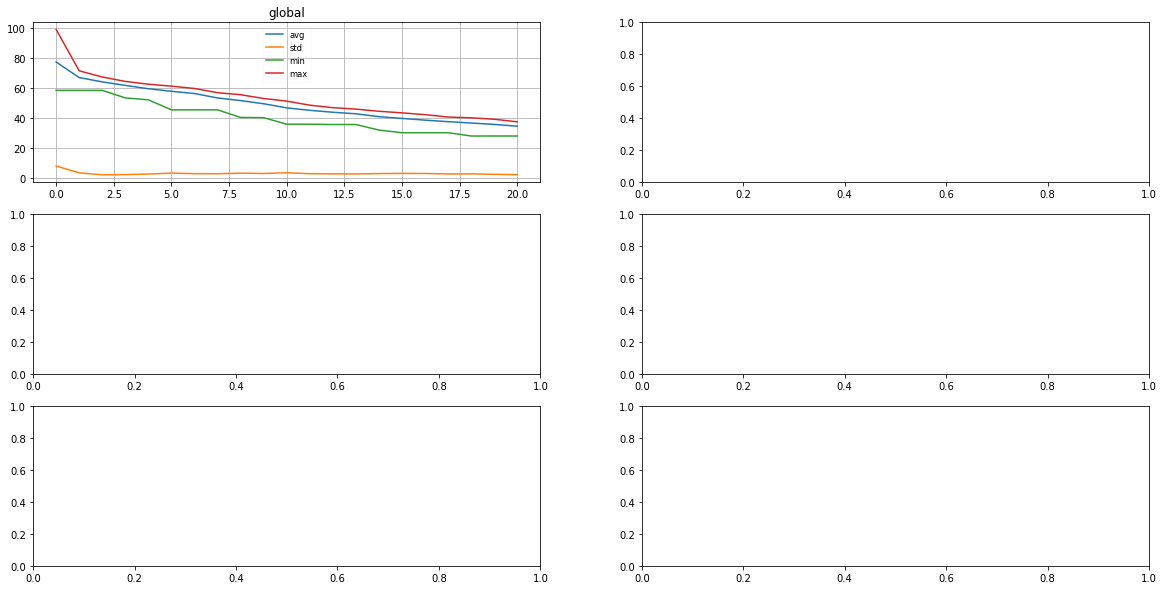

In [21]:
# to plot the log stats
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.gcf().set_size_inches(20, 10)
for i,obj in enumerate(fitWei.keys()):
    for j,stype in enumerate(['avg','std','min','max']):
        dfp = df[df['ridx']==i]
        axes[i//2,i%2].plot(dfp['gen'], dfp[stype], label=stype)

    axes[i//2,i%2].set(title=obj)
    axes[i//2,i%2].grid()
    legend = axes[i//2,i%2].legend(loc='upper center', shadow=False, fontsize='small', framealpha=0.1)

# fig.savefig("05-logstats.png")